# Exercise 7 Solution: Effect Sizes, Significance, and Bayesian Evidence

In this exercise, we explore essential methods for evaluating statistical evidence in neuroscience, focusing not only on whether an effect exists but also on how large and meaningful that effect is. We introduce both frequentest and Bayesian approaches to inference, emphasizing the importance of combining significance testing with measures of effect size and strength of evidence.

Specifically, we will:

1. **p-values and Statistical Significance:** Learn how p-values quantify the probability of observing a test statistic as extreme as—or more extreme than—the one obtained, assuming the null hypothesis is true. We apply this to neuroscience problems such as ERP amplitude comparisons and BCI decoding accuracy to evaluate whether observed differences are statistically significant.

2. **Cohen’s d and Effect Sizes:** Go beyond p-values by computing Cohen’s d to measure the magnitude of an observed effect. We illustrate how even small effects can become statistically significant in large samples, and why effect sizes are critical for interpreting practical or clinical relevance in neuroscience research.

3. **Statistical vs. Practical Significance:** Use simulated EEG and reaction time data to highlight cases where a statistically significant result (low p-value) has a negligible effect size (small d), and vice versa. This helps students distinguish between a "detectable" and a "meaningful" difference in experimental data.

4. **Bayes Factors as an Alternative to p-values:** Introduce Bayes Factors to evaluate how strongly the data supports the alternative hypothesis over the null. Using Pingouin’s bayesfactor_ttest, we compare competing hypotheses in EEG experiments and show how Bayes Factors provide direct evidence that complements traditional hypothesis testing.

5. **Interpreting Bayesian Evidence:** Understand how to interpret Bayes Factors using established thresholds (e.g., BF > 3 for moderate evidence) and how this framework helps avoid binary thinking (“significant” vs “not significant”), especially in borderline cases.

By the end of this exercise, you'll understand how to evaluate results in neuroscience using multiple lenses: statistical significance (p-values), effect size (Cohen’s d), and strength of evidence (Bayes Factors).


In [137]:
import numpy as np
from scipy.stats import ttest_rel
from pingouin import compute_effsize
import matplotlib.pyplot as plt
import pingouin as pg
from scipy.stats import t
import scipy.stats

## Exercise 1: Comparing P300 Amplitudes in an Oddball Task

In [138]:
# Set seed for reproducibility
np.random.seed(42)
n = 2000
scale = 0.3
mean_1 = 5.05
mean_2 = 5.0
# Simulate P300 amplitudes (µV) for 30 participants
# Target condition has slightly higher mean (e.g., 5.2 vs 5.0)
p300_target = np.random.normal(loc=mean_1, scale=scale, size=n)
p300_nontarget = np.random.normal(loc=mean_2, scale=scale, size=n)


In [139]:
# Paired t-test
t_stat, p_val = ttest_rel(p300_target, p300_nontarget)
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val}")


T-statistic: 6.860
P-value: 9.131076637229024e-12


In [140]:
# Cohen's d for paired data
d = compute_effsize(p300_target, p300_nontarget, paired=True, eftype='cohen')
print(f"Cohen's d: {d:.3f}")


Cohen's d: 0.219


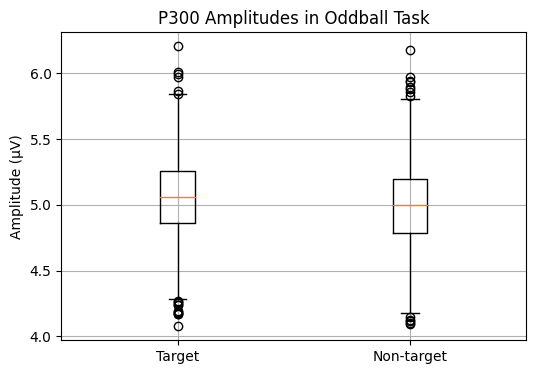

In [141]:
# Visual comparison
plt.figure(figsize=(6, 4))
plt.boxplot([p300_target, p300_nontarget], labels=['Target', 'Non-target'])
plt.title("P300 Amplitudes in Oddball Task")
plt.ylabel("Amplitude (µV)")
plt.grid(True)
plt.show()


### The difference is statistically significant due to the large sample size, but the effect is too small to be practically meaningful, such as for classification in a BCI system. This highlights the importance of reporting both p-values and effect sizes. (You can play with the sample size and the distribution and see what will happen)

## Example 2: Mean BOLD signal in DLPFC

In [150]:
def generate_data(n, effect_size, seed=None):
    """
    Generate two random samples with a specified effect size.

    Parameters:
    n (int): Sample size for each sample.
    effect_size (float): Cohen's d, the effect size.
    seed (int, optional): Seed for random number generator.

    Returns:
    tuple: Two numpy arrays representing the samples.
    """
    if seed is not None:
        np.random.seed(seed)

    mu1, sigma = 0, 1  # Mean and standard deviation of the samples
    mu2 = mu1 + effect_size  # Adjusted mean for the second sample

    sample1 = np.random.normal(loc=mu1, scale=sigma, size=n)
    sample2 = np.random.normal(loc=mu2, scale=sigma, size=n)

    return sample1, sample2

In [151]:
# Simulate paired data
np.random.seed(42)
n = 75
bold_low = np.random.normal(loc=0.8, scale=0.3, size=n)
bold_high = bold_low + np.random.normal(loc=0.1, scale=0.25, size=n)
# bold_high = bold_low + np.random.normal(loc=0.25, scale=0.1, size=n)

# Paired t-test + Cohen's d
t_stat, p_value = scipy.stats.ttest_ind(bold_high, bold_low)



In [152]:
# Compute Cohen's d using pingouin
# results = pg.ttest(x=bold_high, y=bold_low, paired=True)
# t_val = results['T'].values[0]
# p_val = results['p-val'].values[0]
# d = results['cohen-d'].values[0]

# Compute means and standard deviations
mean1 = np.mean(bold_low)
mean2 = np.mean(bold_high)
std1 = np.std(bold_low, ddof=1)  # sample standard deviation
std2 = np.std(bold_high, ddof=1)

# Sample sizes
n1 = len(bold_low)
n2 = len(bold_high)

# Compute pooled standard deviation
pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))

# Compute Cohen's d
cohens_d = np.abs((mean1 - mean2)) / pooled_std


In [153]:
print("T-statistic:", round(t_val, 3))
print("P-value:", p_val)
print(f"Cohen's d: {cohens_d}")


T-statistic: 1.64
P-value: 9.131076637229024e-12
Cohen's d: 0.27122671360953915


In [154]:
def estimate_bayes_factor(sample1, sample2, prior_width=0.707):
    """
    Estimate the Bayes factor for two samples using a t-test.

    Parameters:
    sample1 (array-like): First sample.
    sample2 (array-like): Second sample.
    prior_width (float): Width of the Cauchy prior for the Bayes factor calculation.

    Returns:
    tuple: t-statistic, p-value, and Bayes factor.
    """
    t_stat, p_value = scipy.stats.ttest_ind(sample2, sample1)

    n1, n2 = len(sample1), len(sample2)
    bayes_factor = pg.bayesfactor_ttest(t_stat, nx=n1, ny=n2, paired=False, alternative="two-sided", r=prior_width)

    return bayes_factor

# Calculate Bayes Factor
bf10 = estimate_bayes_factor(bold_low, bold_high, prior_width=0.707)
print("Approximate Bayes Factor BF10:", round(bf10, 3))


Approximate Bayes Factor BF10: 0.621


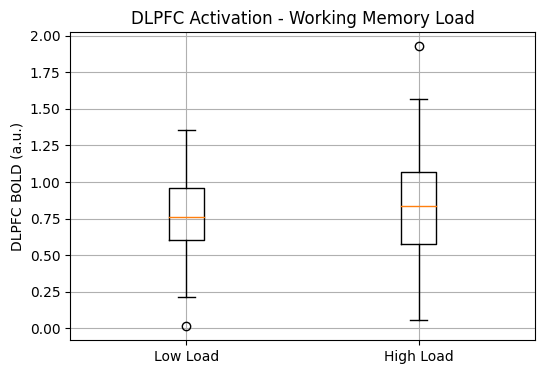

In [155]:
plt.figure(figsize=(6, 4))
plt.boxplot([bold_low, bold_high], labels=["Low Load", "High Load"])
plt.ylabel("DLPFC BOLD (a.u.)")
plt.title("DLPFC Activation - Working Memory Load")
plt.grid(True)
plt.show()
